# DENOISING

##### All algorithms were designed by Hyungjoo Kim and Dataset was provided by UCL

In [36]:
import os
import cv2
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.utils import save_image, make_grid

In [37]:
# Using GPU or CPU
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if cuda:
    print(f'gpu count: {torch.cuda.device_count()}')

gpu count: 1


## Denoising

**Implement denoise_gauss to denoise an image using a 5×5 Gaussian filter.**

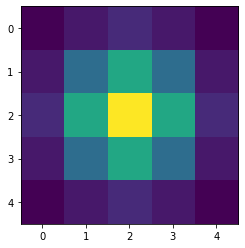

In [38]:
from PIL import Image
noisy_image_filename = "./Datasets/Filtering/noisy_image.png"
image = Image.open(noisy_image_filename)
noisy_image = np.mean(np.array(image), axis = -1)
image_array = np.asarray(image)

# LOAD noisy_image FROM noisy_image_filename
def gfunc(x,y,sigma):
    return (np.exp(-(x**2 + y**2) / (2 * (sigma**2)))) / (2 * 3.14 * (sigma**2))

def denoise_gauss(size, sigma):
    # IMPLEMENT THIS FUNCTION
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i - size[0] // 2, j - size[1] // 2, sigma)
    denoised_image = out / np.sum(out)
    
    return denoised_image

# Convolution
#    for i in range(filtered_image.shape[0]):
#        for j in range(filtered_image.shape[1]):
#            image_crop = image[i:i+filter_size, j:j+filter_size]
#            filtered_image[i,j] = (image_crop * filter).sum()

#denoised_image = denoise_gauss(noisy_image)
(gfw, gfh) = (5, 5)
gaussianFilter = denoise_gauss((gfw,gfh), 1)
plt.imshow(gaussianFilter)

kernel1d = cv2.getGaussianKernel(5, 3)
kernel2d = np.outer(kernel1d, kernel1d.transpose())
low_img_array = cv2.filter2D(image_array, -1, kernel2d)  # convolve
filtered_img = Image.fromarray(low_img_array)

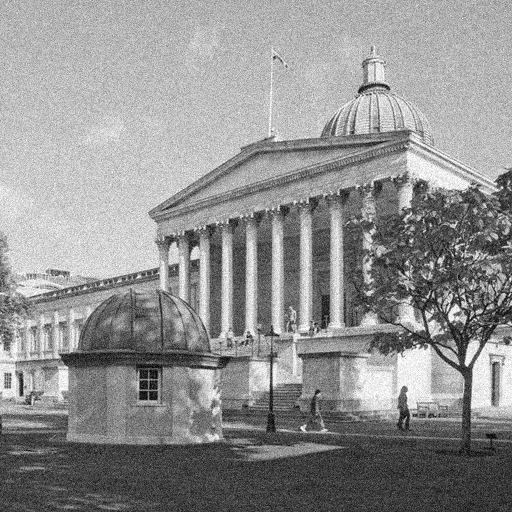

In [39]:
# DISPLAY input_image AND denoised_image here
input_img = Image.fromarray(np.uint8(noisy_image))
input_img

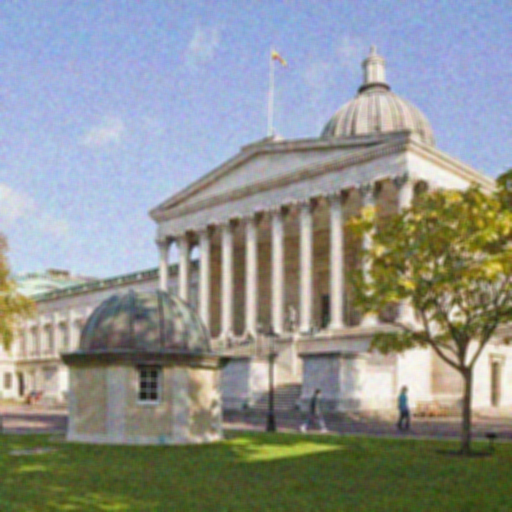

In [40]:
filtered_img

**Implement a pyramidal encoder-decoder to denoise an image. Pairs of noisy and noise-free image patches of size 128×128 for training and testing.**

In [41]:
input_imgs_path = "./Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "./Datasets/Denoising/target_clean_images"

class DenoisingDB(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        self.x_path = input_imgs_path
        self.y_path = cleaned_imgs_path
        self.x_list = os.listdir(self.x_path)
        self.y_list = os.listdir(self.y_path)
        
        self.transform = transforms.Compose([
        transforms.Resize((128, 128)),   # To square array
        transforms.ToTensor()
        ])

    def __len__(self):
        # RETURN SIZE OF DATASET
        assert len(self.x_list) == len(self.y_list)
        length = len(self.x_list)
        
        return length

    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        input_image = Image.open(os.path.join(self.x_path, self.x_list[idx]))
        cleaned_image = Image.open(os.path.join(self.y_path, self.y_list[idx]))
        input_image = self.transform(input_image).to(device)
        cleaned_image = self.transform(cleaned_image).to(device)
        image = {'input_image': input_image, 'cleaned_image': cleaned_image}
        
        return image

class Encoder(nn.Module):
  # IMPLEMENT THIS ENCODER CLASS
    def __init__(self, in_channels = 1, n_layers = 5):
        super(Encoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        layers = []
        for i in range(n_layers):
            layers.append(nn.Conv2d(in_channels = in_channels * (2**i), out_channels = in_channels * (2**(i + 1)), kernel_size = (3, 3), stride = (2, 2), padding = (1, 1)))
            layers.append(nn.MaxPool2d(3, stride = 1, padding = 1))
            layers.append(nn.ReLU())
        self.conv = nn.Sequential(*layers)
        
        # The above for loop is same as
        # self.conv = nn.Sequential(
        # nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.MaxPool2d(3, stride = 1, padding = 1)
        # nn.ReLU(),
        # nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.MaxPool2d(3, stride = 1, padding = 1)
        # nn.ReLU(),
        # nn.Conv2d(in_channels=in_channels*4, out_channels=in_channels*8, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.MaxPool2d(3, stride = 1, padding = 1)
        # nn.ReLU(),
        # nn.Conv2d(in_channels=in_channels*8, out_channels=in_channels*16, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.MaxPool2d(3, stride = 1, padding = 1)
        # nn.ReLU(),
        # nn.Conv2d(in_channels=in_channels*16, out_channels=in_channels*32, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.MaxPool2d(3, stride = 1, padding = 1)
        # nn.ReLU(),
        # )
        
    def forward(self, high_res_image):
        # WRITE YOUR ENCODER ARCHITECTURE HERE
        low_res_image = self.conv(high_res_image)
        
        return low_res_image

class Decoder(nn.Module):
  # IMPLEMENT THIS DECODER CLASS

    def __init__(self, out_channels = 1, n_layers = 5):
        super(Decoder, self).__init__()
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        layers = []
        for i in range(n_layers, 0, -1):    # (start, End, Hop)
            layers.append(nn.ConvTranspose2d(in_channels = out_channels * (2**i), out_channels = out_channels * (2**(i - 1)), kernel_size = (4, 4), stride = (2, 2), padding = (1, 1)))
            layers.append(nn.ReLU())
        #del layers[-1]   # I will make one more the last layer -> sigmoid function
        #layers.append(nn.Conv2d(out_channels, out_channels, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)))
        #layers.append(nn.Sigmoid())   # 5 layers = ReLU and make one more layer -> sigmoid
        self.deconv = nn.Sequential(*layers)  # I add one more layer because the output seems poor results
                                              # If making one more decoder layer, then output would be greater than before.
        
        # The above for loop is same as
        # self.deconv = nn.Sequential(
        # nn.ConvTranspose2d(in_channels=96, out_channels=48, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.ReLU(),
        # nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.ReLU(),
        # nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.ReLU(),
        # nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.ReLU(),
        # nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
        # nn.ReLu(),
        # ) 
    def forward(self, low_res_image):
        # WRITE YOUR DECODER ARCHITECTURE HERE
        denoised_image = self.deconv(low_res_image)
        
        return denoised_image
    
class Denoiser(nn.Module):    # Using GPU
    def __init__(self, n_channels):
        super(Denoiser, self).__init__()
        self.encoder = Encoder(n_channels)
        self.decoder = Decoder(n_channels)
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        return x_hat
        
def loss_function(input, target):
    # WRITE YOUR DENOISING LOSS FUNCTION HERE = L2 loss function
    loss = F.mse_loss(input, target)
    
    return loss

class AverageMeter(object):        # Computes and stores the average and current value
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.value = 0
        self.average = 0
        self.sum = 0
        self.count = 0
    
    def step(self, value, n = 1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

model = Denoiser(n_channels = 1)
model.to(device)

n_epoch = 500
lr = 0.001
batch_size = 16
    
#optimizer = optim.SGD(model.parameters(), lr = lr) # USE THE TORCH API TO WRITE YOUR Stochastic Gradient Descent optimizer function here.
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()

docs_dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)
docs_dataloader = DataLoader(docs_dataset, batch_size = batch_size)

In [42]:
# Training loop
train_meter = AverageMeter()
best_loss = float('inf')
for epoch in range(n_epoch):
    train_meter.reset()
    ## fill in your training loop here. Use the loss function and SGD optimizer
    for i, data in enumerate(docs_dataloader):
        input_image = data['input_image']
        cleaned_image = data['cleaned_image']
        recons_image = model(input_image)
        loss = criterion(recons_image, cleaned_image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.step(loss.item())
        print('[Epoch: %s / %s][Batch: %s / %s][Loss: %.7f (%.7f)]' % (epoch + 1, n_epoch, i, len(docs_dataloader) - 1, loss.item(), train_meter.average))

[Epoch: 1 / 500][Batch: 0 / 8][Loss: 0.6997635 (0.6997635)]
[Epoch: 1 / 500][Batch: 1 / 8][Loss: 0.7321509 (0.7159572)]
[Epoch: 1 / 500][Batch: 2 / 8][Loss: 0.7182894 (0.7167346)]
[Epoch: 1 / 500][Batch: 3 / 8][Loss: 0.6883760 (0.7096450)]
[Epoch: 1 / 500][Batch: 4 / 8][Loss: 0.7026753 (0.7082510)]
[Epoch: 1 / 500][Batch: 5 / 8][Loss: 0.7026168 (0.7073120)]
[Epoch: 1 / 500][Batch: 6 / 8][Loss: 0.6992383 (0.7061586)]
[Epoch: 1 / 500][Batch: 7 / 8][Loss: 0.7110184 (0.7067661)]
[Epoch: 1 / 500][Batch: 8 / 8][Loss: 0.7139443 (0.7075637)]
[Epoch: 2 / 500][Batch: 0 / 8][Loss: 0.6809365 (0.6809365)]
[Epoch: 2 / 500][Batch: 1 / 8][Loss: 0.7129648 (0.6969506)]
[Epoch: 2 / 500][Batch: 2 / 8][Loss: 0.6993172 (0.6977395)]
[Epoch: 2 / 500][Batch: 3 / 8][Loss: 0.6700610 (0.6908199)]
[Epoch: 2 / 500][Batch: 4 / 8][Loss: 0.6842903 (0.6895140)]
[Epoch: 2 / 500][Batch: 5 / 8][Loss: 0.6843430 (0.6886521)]
[Epoch: 2 / 500][Batch: 6 / 8][Loss: 0.6811590 (0.6875817)]
[Epoch: 2 / 500][Batch: 7 / 8][Loss: 0.6

[Epoch: 16 / 500][Batch: 3 / 8][Loss: 0.2086447 (0.2266779)]
[Epoch: 16 / 500][Batch: 4 / 8][Loss: 0.2076834 (0.2228790)]
[Epoch: 16 / 500][Batch: 5 / 8][Loss: 0.2023133 (0.2194514)]
[Epoch: 16 / 500][Batch: 6 / 8][Loss: 0.1975447 (0.2163219)]
[Epoch: 16 / 500][Batch: 7 / 8][Loss: 0.1936335 (0.2134858)]
[Epoch: 16 / 500][Batch: 8 / 8][Loss: 0.1849868 (0.2103193)]
[Epoch: 17 / 500][Batch: 0 / 8][Loss: 0.1804322 (0.1804322)]
[Epoch: 17 / 500][Batch: 1 / 8][Loss: 0.1780321 (0.1792321)]
[Epoch: 17 / 500][Batch: 2 / 8][Loss: 0.1615045 (0.1733229)]
[Epoch: 17 / 500][Batch: 3 / 8][Loss: 0.1555342 (0.1688757)]
[Epoch: 17 / 500][Batch: 4 / 8][Loss: 0.1536746 (0.1658355)]
[Epoch: 17 / 500][Batch: 5 / 8][Loss: 0.1497479 (0.1631542)]
[Epoch: 17 / 500][Batch: 6 / 8][Loss: 0.1470186 (0.1608491)]
[Epoch: 17 / 500][Batch: 7 / 8][Loss: 0.1429808 (0.1586156)]
[Epoch: 17 / 500][Batch: 8 / 8][Loss: 0.1341238 (0.1558943)]
[Epoch: 18 / 500][Batch: 0 / 8][Loss: 0.1317939 (0.1317939)]
[Epoch: 18 / 500][Batch:

[Epoch: 31 / 500][Batch: 4 / 8][Loss: 0.0335239 (0.0335069)]
[Epoch: 31 / 500][Batch: 5 / 8][Loss: 0.0323174 (0.0333086)]
[Epoch: 31 / 500][Batch: 6 / 8][Loss: 0.0339639 (0.0334022)]
[Epoch: 31 / 500][Batch: 7 / 8][Loss: 0.0321012 (0.0332396)]
[Epoch: 31 / 500][Batch: 8 / 8][Loss: 0.0282999 (0.0326908)]
[Epoch: 32 / 500][Batch: 0 / 8][Loss: 0.0389135 (0.0389135)]
[Epoch: 32 / 500][Batch: 1 / 8][Loss: 0.0338018 (0.0363576)]
[Epoch: 32 / 500][Batch: 2 / 8][Loss: 0.0256400 (0.0327851)]
[Epoch: 32 / 500][Batch: 3 / 8][Loss: 0.0330338 (0.0328473)]
[Epoch: 32 / 500][Batch: 4 / 8][Loss: 0.0329256 (0.0328630)]
[Epoch: 32 / 500][Batch: 5 / 8][Loss: 0.0316029 (0.0326529)]
[Epoch: 32 / 500][Batch: 6 / 8][Loss: 0.0331545 (0.0327246)]
[Epoch: 32 / 500][Batch: 7 / 8][Loss: 0.0313293 (0.0325502)]
[Epoch: 32 / 500][Batch: 8 / 8][Loss: 0.0276771 (0.0320087)]
[Epoch: 33 / 500][Batch: 0 / 8][Loss: 0.0383822 (0.0383822)]
[Epoch: 33 / 500][Batch: 1 / 8][Loss: 0.0332334 (0.0358078)]
[Epoch: 33 / 500][Batch:

[Epoch: 46 / 500][Batch: 5 / 8][Loss: 0.0263322 (0.0278713)]
[Epoch: 46 / 500][Batch: 6 / 8][Loss: 0.0272471 (0.0277822)]
[Epoch: 46 / 500][Batch: 7 / 8][Loss: 0.0257191 (0.0275243)]
[Epoch: 46 / 500][Batch: 8 / 8][Loss: 0.0227734 (0.0269964)]
[Epoch: 47 / 500][Batch: 0 / 8][Loss: 0.0336740 (0.0336740)]
[Epoch: 47 / 500][Batch: 1 / 8][Loss: 0.0285305 (0.0311023)]
[Epoch: 47 / 500][Batch: 2 / 8][Loss: 0.0209997 (0.0277347)]
[Epoch: 47 / 500][Batch: 3 / 8][Loss: 0.0284907 (0.0279237)]
[Epoch: 47 / 500][Batch: 4 / 8][Loss: 0.0282906 (0.0279971)]
[Epoch: 47 / 500][Batch: 5 / 8][Loss: 0.0261385 (0.0276873)]
[Epoch: 47 / 500][Batch: 6 / 8][Loss: 0.0270529 (0.0275967)]
[Epoch: 47 / 500][Batch: 7 / 8][Loss: 0.0255345 (0.0273389)]
[Epoch: 47 / 500][Batch: 8 / 8][Loss: 0.0225886 (0.0268111)]
[Epoch: 48 / 500][Batch: 0 / 8][Loss: 0.0334826 (0.0334826)]
[Epoch: 48 / 500][Batch: 1 / 8][Loss: 0.0283447 (0.0309137)]
[Epoch: 48 / 500][Batch: 2 / 8][Loss: 0.0208290 (0.0275521)]
[Epoch: 48 / 500][Batch:

[Epoch: 61 / 500][Batch: 5 / 8][Loss: 0.0243986 (0.0258467)]
[Epoch: 61 / 500][Batch: 6 / 8][Loss: 0.0253736 (0.0257791)]
[Epoch: 61 / 500][Batch: 7 / 8][Loss: 0.0238489 (0.0255378)]
[Epoch: 61 / 500][Batch: 8 / 8][Loss: 0.0208336 (0.0250152)]
[Epoch: 62 / 500][Batch: 0 / 8][Loss: 0.0317199 (0.0317199)]
[Epoch: 62 / 500][Batch: 1 / 8][Loss: 0.0265707 (0.0291453)]
[Epoch: 62 / 500][Batch: 2 / 8][Loss: 0.0190569 (0.0257825)]
[Epoch: 62 / 500][Batch: 3 / 8][Loss: 0.0265379 (0.0259714)]
[Epoch: 62 / 500][Batch: 4 / 8][Loss: 0.0263265 (0.0260424)]
[Epoch: 62 / 500][Batch: 5 / 8][Loss: 0.0243099 (0.0257536)]
[Epoch: 62 / 500][Batch: 6 / 8][Loss: 0.0252932 (0.0256879)]
[Epoch: 62 / 500][Batch: 7 / 8][Loss: 0.0237704 (0.0254482)]
[Epoch: 62 / 500][Batch: 8 / 8][Loss: 0.0207452 (0.0249256)]
[Epoch: 63 / 500][Batch: 0 / 8][Loss: 0.0316195 (0.0316195)]
[Epoch: 63 / 500][Batch: 1 / 8][Loss: 0.0264766 (0.0290481)]
[Epoch: 63 / 500][Batch: 2 / 8][Loss: 0.0189646 (0.0256869)]
[Epoch: 63 / 500][Batch:

[Epoch: 76 / 500][Batch: 6 / 8][Loss: 0.0245851 (0.0247255)]
[Epoch: 76 / 500][Batch: 7 / 8][Loss: 0.0230122 (0.0245114)]
[Epoch: 76 / 500][Batch: 8 / 8][Loss: 0.0197965 (0.0239875)]
[Epoch: 77 / 500][Batch: 0 / 8][Loss: 0.0305753 (0.0305753)]
[Epoch: 77 / 500][Batch: 1 / 8][Loss: 0.0254973 (0.0280363)]
[Epoch: 77 / 500][Batch: 2 / 8][Loss: 0.0179658 (0.0246794)]
[Epoch: 77 / 500][Batch: 3 / 8][Loss: 0.0254319 (0.0248675)]
[Epoch: 77 / 500][Batch: 4 / 8][Loss: 0.0252424 (0.0249425)]
[Epoch: 77 / 500][Batch: 5 / 8][Loss: 0.0234388 (0.0246919)]
[Epoch: 77 / 500][Batch: 6 / 8][Loss: 0.0245497 (0.0246716)]
[Epoch: 77 / 500][Batch: 7 / 8][Loss: 0.0229713 (0.0244590)]
[Epoch: 77 / 500][Batch: 8 / 8][Loss: 0.0197473 (0.0239355)]
[Epoch: 78 / 500][Batch: 0 / 8][Loss: 0.0305176 (0.0305176)]
[Epoch: 78 / 500][Batch: 1 / 8][Loss: 0.0254441 (0.0279809)]
[Epoch: 78 / 500][Batch: 2 / 8][Loss: 0.0179085 (0.0246234)]
[Epoch: 78 / 500][Batch: 3 / 8][Loss: 0.0253759 (0.0248115)]
[Epoch: 78 / 500][Batch:

[Epoch: 91 / 500][Batch: 6 / 8][Loss: 0.0240647 (0.0240303)]
[Epoch: 91 / 500][Batch: 7 / 8][Loss: 0.0225169 (0.0238411)]
[Epoch: 91 / 500][Batch: 8 / 8][Loss: 0.0191604 (0.0233211)]
[Epoch: 92 / 500][Batch: 0 / 8][Loss: 0.0297450 (0.0297450)]
[Epoch: 92 / 500][Batch: 1 / 8][Loss: 0.0248308 (0.0272879)]
[Epoch: 92 / 500][Batch: 2 / 8][Loss: 0.0172819 (0.0239525)]
[Epoch: 92 / 500][Batch: 3 / 8][Loss: 0.0247166 (0.0241435)]
[Epoch: 92 / 500][Batch: 4 / 8][Loss: 0.0245240 (0.0242196)]
[Epoch: 92 / 500][Batch: 5 / 8][Loss: 0.0228280 (0.0239877)]
[Epoch: 92 / 500][Batch: 6 / 8][Loss: 0.0240420 (0.0239955)]
[Epoch: 92 / 500][Batch: 7 / 8][Loss: 0.0224975 (0.0238082)]
[Epoch: 92 / 500][Batch: 8 / 8][Loss: 0.0191203 (0.0232873)]
[Epoch: 93 / 500][Batch: 0 / 8][Loss: 0.0297022 (0.0297022)]
[Epoch: 93 / 500][Batch: 1 / 8][Loss: 0.0247869 (0.0272446)]
[Epoch: 93 / 500][Batch: 2 / 8][Loss: 0.0172429 (0.0239107)]
[Epoch: 93 / 500][Batch: 3 / 8][Loss: 0.0246767 (0.0241022)]
[Epoch: 93 / 500][Batch:

[Epoch: 106 / 500][Batch: 6 / 8][Loss: 0.0237590 (0.0235822)]
[Epoch: 106 / 500][Batch: 7 / 8][Loss: 0.0222082 (0.0234105)]
[Epoch: 106 / 500][Batch: 8 / 8][Loss: 0.0187490 (0.0228925)]
[Epoch: 107 / 500][Batch: 0 / 8][Loss: 0.0292472 (0.0292472)]
[Epoch: 107 / 500][Batch: 1 / 8][Loss: 0.0244084 (0.0268278)]
[Epoch: 107 / 500][Batch: 2 / 8][Loss: 0.0167864 (0.0234806)]
[Epoch: 107 / 500][Batch: 3 / 8][Loss: 0.0242188 (0.0236652)]
[Epoch: 107 / 500][Batch: 4 / 8][Loss: 0.0240400 (0.0237402)]
[Epoch: 107 / 500][Batch: 5 / 8][Loss: 0.0224619 (0.0235271)]
[Epoch: 107 / 500][Batch: 6 / 8][Loss: 0.0237368 (0.0235571)]
[Epoch: 107 / 500][Batch: 7 / 8][Loss: 0.0221885 (0.0233860)]
[Epoch: 107 / 500][Batch: 8 / 8][Loss: 0.0187282 (0.0228685)]
[Epoch: 108 / 500][Batch: 0 / 8][Loss: 0.0292168 (0.0292168)]
[Epoch: 108 / 500][Batch: 1 / 8][Loss: 0.0243856 (0.0268012)]
[Epoch: 108 / 500][Batch: 2 / 8][Loss: 0.0167579 (0.0234534)]
[Epoch: 108 / 500][Batch: 3 / 8][Loss: 0.0241926 (0.0236382)]
[Epoch: 

[Epoch: 121 / 500][Batch: 6 / 8][Loss: 0.0235104 (0.0232448)]
[Epoch: 121 / 500][Batch: 7 / 8][Loss: 0.0219795 (0.0230867)]
[Epoch: 121 / 500][Batch: 8 / 8][Loss: 0.0184749 (0.0225742)]
[Epoch: 122 / 500][Batch: 0 / 8][Loss: 0.0288846 (0.0288846)]
[Epoch: 122 / 500][Batch: 1 / 8][Loss: 0.0241311 (0.0265079)]
[Epoch: 122 / 500][Batch: 2 / 8][Loss: 0.0164074 (0.0231410)]
[Epoch: 122 / 500][Batch: 3 / 8][Loss: 0.0238287 (0.0233129)]
[Epoch: 122 / 500][Batch: 4 / 8][Loss: 0.0236594 (0.0233822)]
[Epoch: 122 / 500][Batch: 5 / 8][Loss: 0.0221779 (0.0231815)]
[Epoch: 122 / 500][Batch: 6 / 8][Loss: 0.0234925 (0.0232259)]
[Epoch: 122 / 500][Batch: 7 / 8][Loss: 0.0219656 (0.0230684)]
[Epoch: 122 / 500][Batch: 8 / 8][Loss: 0.0184628 (0.0225567)]
[Epoch: 123 / 500][Batch: 0 / 8][Loss: 0.0288672 (0.0288672)]
[Epoch: 123 / 500][Batch: 1 / 8][Loss: 0.0241196 (0.0264934)]
[Epoch: 123 / 500][Batch: 2 / 8][Loss: 0.0163856 (0.0231241)]
[Epoch: 123 / 500][Batch: 3 / 8][Loss: 0.0238033 (0.0232939)]
[Epoch: 

[Epoch: 136 / 500][Batch: 6 / 8][Loss: 0.0232974 (0.0229723)]
[Epoch: 136 / 500][Batch: 7 / 8][Loss: 0.0218104 (0.0228271)]
[Epoch: 136 / 500][Batch: 8 / 8][Loss: 0.0183177 (0.0223261)]
[Epoch: 137 / 500][Batch: 0 / 8][Loss: 0.0286253 (0.0286253)]
[Epoch: 137 / 500][Batch: 1 / 8][Loss: 0.0239727 (0.0262990)]
[Epoch: 137 / 500][Batch: 2 / 8][Loss: 0.0160815 (0.0228932)]
[Epoch: 137 / 500][Batch: 3 / 8][Loss: 0.0234702 (0.0230374)]
[Epoch: 137 / 500][Batch: 4 / 8][Loss: 0.0233228 (0.0230945)]
[Epoch: 137 / 500][Batch: 5 / 8][Loss: 0.0219325 (0.0229008)]
[Epoch: 137 / 500][Batch: 6 / 8][Loss: 0.0232823 (0.0229553)]
[Epoch: 137 / 500][Batch: 7 / 8][Loss: 0.0217987 (0.0228107)]
[Epoch: 137 / 500][Batch: 8 / 8][Loss: 0.0183116 (0.0223108)]
[Epoch: 138 / 500][Batch: 0 / 8][Loss: 0.0286165 (0.0286165)]
[Epoch: 138 / 500][Batch: 1 / 8][Loss: 0.0239663 (0.0262914)]
[Epoch: 138 / 500][Batch: 2 / 8][Loss: 0.0160612 (0.0228813)]
[Epoch: 138 / 500][Batch: 3 / 8][Loss: 0.0234459 (0.0230225)]
[Epoch: 

[Epoch: 151 / 500][Batch: 6 / 8][Loss: 0.0230855 (0.0227355)]
[Epoch: 151 / 500][Batch: 7 / 8][Loss: 0.0216618 (0.0226013)]
[Epoch: 151 / 500][Batch: 8 / 8][Loss: 0.0182362 (0.0221163)]
[Epoch: 152 / 500][Batch: 0 / 8][Loss: 0.0284351 (0.0284351)]
[Epoch: 152 / 500][Batch: 1 / 8][Loss: 0.0239002 (0.0261676)]
[Epoch: 152 / 500][Batch: 2 / 8][Loss: 0.0157982 (0.0227112)]
[Epoch: 152 / 500][Batch: 3 / 8][Loss: 0.0231284 (0.0228155)]
[Epoch: 152 / 500][Batch: 4 / 8][Loss: 0.0230100 (0.0228544)]
[Epoch: 152 / 500][Batch: 5 / 8][Loss: 0.0216990 (0.0226618)]
[Epoch: 152 / 500][Batch: 6 / 8][Loss: 0.0230737 (0.0227206)]
[Epoch: 152 / 500][Batch: 7 / 8][Loss: 0.0216537 (0.0225873)]
[Epoch: 152 / 500][Batch: 8 / 8][Loss: 0.0182343 (0.0221036)]
[Epoch: 153 / 500][Batch: 0 / 8][Loss: 0.0284270 (0.0284270)]
[Epoch: 153 / 500][Batch: 1 / 8][Loss: 0.0239002 (0.0261636)]
[Epoch: 153 / 500][Batch: 2 / 8][Loss: 0.0157785 (0.0227019)]
[Epoch: 153 / 500][Batch: 3 / 8][Loss: 0.0231032 (0.0228023)]
[Epoch: 

[Epoch: 166 / 500][Batch: 6 / 8][Loss: 0.0228640 (0.0225204)]
[Epoch: 166 / 500][Batch: 7 / 8][Loss: 0.0215269 (0.0223963)]
[Epoch: 166 / 500][Batch: 8 / 8][Loss: 0.0182274 (0.0219331)]
[Epoch: 167 / 500][Batch: 0 / 8][Loss: 0.0283237 (0.0283237)]
[Epoch: 167 / 500][Batch: 1 / 8][Loss: 0.0239105 (0.0261171)]
[Epoch: 167 / 500][Batch: 2 / 8][Loss: 0.0155381 (0.0225908)]
[Epoch: 167 / 500][Batch: 3 / 8][Loss: 0.0227821 (0.0226386)]
[Epoch: 167 / 500][Batch: 4 / 8][Loss: 0.0226841 (0.0226477)]
[Epoch: 167 / 500][Batch: 5 / 8][Loss: 0.0214461 (0.0224474)]
[Epoch: 167 / 500][Batch: 6 / 8][Loss: 0.0228388 (0.0225033)]
[Epoch: 167 / 500][Batch: 7 / 8][Loss: 0.0215126 (0.0223795)]
[Epoch: 167 / 500][Batch: 8 / 8][Loss: 0.0182328 (0.0219187)]
[Epoch: 168 / 500][Batch: 0 / 8][Loss: 0.0283289 (0.0283289)]
[Epoch: 168 / 500][Batch: 1 / 8][Loss: 0.0239126 (0.0261207)]
[Epoch: 168 / 500][Batch: 2 / 8][Loss: 0.0155250 (0.0225888)]
[Epoch: 168 / 500][Batch: 3 / 8][Loss: 0.0227604 (0.0226317)]
[Epoch: 

[Epoch: 181 / 500][Batch: 6 / 8][Loss: 0.0226382 (0.0223295)]
[Epoch: 181 / 500][Batch: 7 / 8][Loss: 0.0214000 (0.0222133)]
[Epoch: 181 / 500][Batch: 8 / 8][Loss: 0.0182677 (0.0217749)]
[Epoch: 182 / 500][Batch: 0 / 8][Loss: 0.0282712 (0.0282712)]
[Epoch: 182 / 500][Batch: 1 / 8][Loss: 0.0239563 (0.0261138)]
[Epoch: 182 / 500][Batch: 2 / 8][Loss: 0.0153265 (0.0225180)]
[Epoch: 182 / 500][Batch: 3 / 8][Loss: 0.0224458 (0.0225000)]
[Epoch: 182 / 500][Batch: 4 / 8][Loss: 0.0223778 (0.0224755)]
[Epoch: 182 / 500][Batch: 5 / 8][Loss: 0.0212134 (0.0222652)]
[Epoch: 182 / 500][Batch: 6 / 8][Loss: 0.0226138 (0.0223150)]
[Epoch: 182 / 500][Batch: 7 / 8][Loss: 0.0213808 (0.0221982)]
[Epoch: 182 / 500][Batch: 8 / 8][Loss: 0.0182738 (0.0217622)]
[Epoch: 183 / 500][Batch: 0 / 8][Loss: 0.0282833 (0.0282833)]
[Epoch: 183 / 500][Batch: 1 / 8][Loss: 0.0239632 (0.0261232)]
[Epoch: 183 / 500][Batch: 2 / 8][Loss: 0.0153066 (0.0225177)]
[Epoch: 183 / 500][Batch: 3 / 8][Loss: 0.0224142 (0.0224918)]
[Epoch: 

[Epoch: 196 / 500][Batch: 4 / 8][Loss: 0.0220860 (0.0223170)]
[Epoch: 196 / 500][Batch: 5 / 8][Loss: 0.0210585 (0.0221072)]
[Epoch: 196 / 500][Batch: 6 / 8][Loss: 0.0225149 (0.0221655)]
[Epoch: 196 / 500][Batch: 7 / 8][Loss: 0.0213411 (0.0220624)]
[Epoch: 196 / 500][Batch: 8 / 8][Loss: 0.0182943 (0.0216437)]
[Epoch: 197 / 500][Batch: 0 / 8][Loss: 0.0282059 (0.0282059)]
[Epoch: 197 / 500][Batch: 1 / 8][Loss: 0.0239681 (0.0260870)]
[Epoch: 197 / 500][Batch: 2 / 8][Loss: 0.0151462 (0.0224401)]
[Epoch: 197 / 500][Batch: 3 / 8][Loss: 0.0221251 (0.0223613)]
[Epoch: 197 / 500][Batch: 4 / 8][Loss: 0.0220740 (0.0223039)]
[Epoch: 197 / 500][Batch: 5 / 8][Loss: 0.0210489 (0.0220947)]
[Epoch: 197 / 500][Batch: 6 / 8][Loss: 0.0224912 (0.0221513)]
[Epoch: 197 / 500][Batch: 7 / 8][Loss: 0.0213228 (0.0220478)]
[Epoch: 197 / 500][Batch: 8 / 8][Loss: 0.0183317 (0.0216349)]
[Epoch: 198 / 500][Batch: 0 / 8][Loss: 0.0282670 (0.0282670)]
[Epoch: 198 / 500][Batch: 1 / 8][Loss: 0.0240261 (0.0261465)]
[Epoch: 

[Epoch: 211 / 500][Batch: 3 / 8][Loss: 0.0217548 (0.0222403)]
[Epoch: 211 / 500][Batch: 4 / 8][Loss: 0.0217235 (0.0221370)]
[Epoch: 211 / 500][Batch: 5 / 8][Loss: 0.0209242 (0.0219348)]
[Epoch: 211 / 500][Batch: 6 / 8][Loss: 0.0224877 (0.0220138)]
[Epoch: 211 / 500][Batch: 7 / 8][Loss: 0.0213471 (0.0219305)]
[Epoch: 211 / 500][Batch: 8 / 8][Loss: 0.0183401 (0.0215315)]
[Epoch: 212 / 500][Batch: 0 / 8][Loss: 0.0281657 (0.0281657)]
[Epoch: 212 / 500][Batch: 1 / 8][Loss: 0.0239787 (0.0260722)]
[Epoch: 212 / 500][Batch: 2 / 8][Loss: 0.0149526 (0.0223657)]
[Epoch: 212 / 500][Batch: 3 / 8][Loss: 0.0217969 (0.0222235)]
[Epoch: 212 / 500][Batch: 4 / 8][Loss: 0.0217446 (0.0221277)]
[Epoch: 212 / 500][Batch: 5 / 8][Loss: 0.0209282 (0.0219278)]
[Epoch: 212 / 500][Batch: 6 / 8][Loss: 0.0224632 (0.0220043)]
[Epoch: 212 / 500][Batch: 7 / 8][Loss: 0.0213268 (0.0219196)]
[Epoch: 212 / 500][Batch: 8 / 8][Loss: 0.0183296 (0.0215207)]
[Epoch: 213 / 500][Batch: 0 / 8][Loss: 0.0281695 (0.0281695)]
[Epoch: 

[Epoch: 226 / 500][Batch: 3 / 8][Loss: 0.0215211 (0.0221309)]
[Epoch: 226 / 500][Batch: 4 / 8][Loss: 0.0214416 (0.0219930)]
[Epoch: 226 / 500][Batch: 5 / 8][Loss: 0.0207982 (0.0217939)]
[Epoch: 226 / 500][Batch: 6 / 8][Loss: 0.0224115 (0.0218821)]
[Epoch: 226 / 500][Batch: 7 / 8][Loss: 0.0213545 (0.0218162)]
[Epoch: 226 / 500][Batch: 8 / 8][Loss: 0.0183623 (0.0214324)]
[Epoch: 227 / 500][Batch: 0 / 8][Loss: 0.0280930 (0.0280930)]
[Epoch: 227 / 500][Batch: 1 / 8][Loss: 0.0239918 (0.0260424)]
[Epoch: 227 / 500][Batch: 2 / 8][Loss: 0.0148445 (0.0223098)]
[Epoch: 227 / 500][Batch: 3 / 8][Loss: 0.0215065 (0.0221090)]
[Epoch: 227 / 500][Batch: 4 / 8][Loss: 0.0214070 (0.0219686)]
[Epoch: 227 / 500][Batch: 5 / 8][Loss: 0.0207774 (0.0217700)]
[Epoch: 227 / 500][Batch: 6 / 8][Loss: 0.0223898 (0.0218586)]
[Epoch: 227 / 500][Batch: 7 / 8][Loss: 0.0213551 (0.0217956)]
[Epoch: 227 / 500][Batch: 8 / 8][Loss: 0.0183804 (0.0214162)]
[Epoch: 228 / 500][Batch: 0 / 8][Loss: 0.0280929 (0.0280929)]
[Epoch: 

[Epoch: 241 / 500][Batch: 2 / 8][Loss: 0.0148599 (0.0223425)]
[Epoch: 241 / 500][Batch: 3 / 8][Loss: 0.0212966 (0.0220810)]
[Epoch: 241 / 500][Batch: 4 / 8][Loss: 0.0210866 (0.0218821)]
[Epoch: 241 / 500][Batch: 5 / 8][Loss: 0.0206970 (0.0216846)]
[Epoch: 241 / 500][Batch: 6 / 8][Loss: 0.0223916 (0.0217856)]
[Epoch: 241 / 500][Batch: 7 / 8][Loss: 0.0214737 (0.0217466)]
[Epoch: 241 / 500][Batch: 8 / 8][Loss: 0.0184816 (0.0213838)]
[Epoch: 242 / 500][Batch: 0 / 8][Loss: 0.0280394 (0.0280394)]
[Epoch: 242 / 500][Batch: 1 / 8][Loss: 0.0240381 (0.0260387)]
[Epoch: 242 / 500][Batch: 2 / 8][Loss: 0.0148774 (0.0223183)]
[Epoch: 242 / 500][Batch: 3 / 8][Loss: 0.0213079 (0.0220657)]
[Epoch: 242 / 500][Batch: 4 / 8][Loss: 0.0210788 (0.0218683)]
[Epoch: 242 / 500][Batch: 5 / 8][Loss: 0.0207280 (0.0216783)]
[Epoch: 242 / 500][Batch: 6 / 8][Loss: 0.0224173 (0.0217838)]
[Epoch: 242 / 500][Batch: 7 / 8][Loss: 0.0214968 (0.0217480)]
[Epoch: 242 / 500][Batch: 8 / 8][Loss: 0.0185163 (0.0213889)]
[Epoch: 

[Epoch: 256 / 500][Batch: 0 / 8][Loss: 0.0278205 (0.0278205)]
[Epoch: 256 / 500][Batch: 1 / 8][Loss: 0.0241862 (0.0260034)]
[Epoch: 256 / 500][Batch: 2 / 8][Loss: 0.0155988 (0.0225352)]
[Epoch: 256 / 500][Batch: 3 / 8][Loss: 0.0218078 (0.0223533)]
[Epoch: 256 / 500][Batch: 4 / 8][Loss: 0.0206685 (0.0220164)]
[Epoch: 256 / 500][Batch: 5 / 8][Loss: 0.0207348 (0.0218028)]
[Epoch: 256 / 500][Batch: 6 / 8][Loss: 0.0228399 (0.0219509)]
[Epoch: 256 / 500][Batch: 7 / 8][Loss: 0.0223607 (0.0220022)]
[Epoch: 256 / 500][Batch: 8 / 8][Loss: 0.0191297 (0.0216830)]
[Epoch: 257 / 500][Batch: 0 / 8][Loss: 0.0277887 (0.0277887)]
[Epoch: 257 / 500][Batch: 1 / 8][Loss: 0.0242133 (0.0260010)]
[Epoch: 257 / 500][Batch: 2 / 8][Loss: 0.0157397 (0.0225806)]
[Epoch: 257 / 500][Batch: 3 / 8][Loss: 0.0219815 (0.0224308)]
[Epoch: 257 / 500][Batch: 4 / 8][Loss: 0.0206154 (0.0220677)]
[Epoch: 257 / 500][Batch: 5 / 8][Loss: 0.0207040 (0.0218404)]
[Epoch: 257 / 500][Batch: 6 / 8][Loss: 0.0229152 (0.0219940)]
[Epoch: 

[Epoch: 270 / 500][Batch: 8 / 8][Loss: 0.0198503 (0.0221843)]
[Epoch: 271 / 500][Batch: 0 / 8][Loss: 0.0287374 (0.0287374)]
[Epoch: 271 / 500][Batch: 1 / 8][Loss: 0.0266850 (0.0277112)]
[Epoch: 271 / 500][Batch: 2 / 8][Loss: 0.0146156 (0.0233460)]
[Epoch: 271 / 500][Batch: 3 / 8][Loss: 0.0204238 (0.0226154)]
[Epoch: 271 / 500][Batch: 4 / 8][Loss: 0.0210167 (0.0222957)]
[Epoch: 271 / 500][Batch: 5 / 8][Loss: 0.0216148 (0.0221822)]
[Epoch: 271 / 500][Batch: 6 / 8][Loss: 0.0234181 (0.0223588)]
[Epoch: 271 / 500][Batch: 7 / 8][Loss: 0.0209605 (0.0221840)]
[Epoch: 271 / 500][Batch: 8 / 8][Loss: 0.0192061 (0.0218531)]
[Epoch: 272 / 500][Batch: 0 / 8][Loss: 0.0282248 (0.0282248)]
[Epoch: 272 / 500][Batch: 1 / 8][Loss: 0.0260422 (0.0271335)]
[Epoch: 272 / 500][Batch: 2 / 8][Loss: 0.0146421 (0.0229697)]
[Epoch: 272 / 500][Batch: 3 / 8][Loss: 0.0202747 (0.0222959)]
[Epoch: 272 / 500][Batch: 4 / 8][Loss: 0.0206494 (0.0219666)]
[Epoch: 272 / 500][Batch: 5 / 8][Loss: 0.0210148 (0.0218080)]
[Epoch: 

[Epoch: 285 / 500][Batch: 6 / 8][Loss: 0.0225556 (0.0213948)]
[Epoch: 285 / 500][Batch: 7 / 8][Loss: 0.0210380 (0.0213502)]
[Epoch: 285 / 500][Batch: 8 / 8][Loss: 0.0187583 (0.0210622)]
[Epoch: 286 / 500][Batch: 0 / 8][Loss: 0.0276992 (0.0276992)]
[Epoch: 286 / 500][Batch: 1 / 8][Loss: 0.0245748 (0.0261370)]
[Epoch: 286 / 500][Batch: 2 / 8][Loss: 0.0139620 (0.0220787)]
[Epoch: 286 / 500][Batch: 3 / 8][Loss: 0.0202013 (0.0216093)]
[Epoch: 286 / 500][Batch: 4 / 8][Loss: 0.0203569 (0.0213588)]
[Epoch: 286 / 500][Batch: 5 / 8][Loss: 0.0203389 (0.0211889)]
[Epoch: 286 / 500][Batch: 6 / 8][Loss: 0.0225641 (0.0213853)]
[Epoch: 286 / 500][Batch: 7 / 8][Loss: 0.0210420 (0.0213424)]
[Epoch: 286 / 500][Batch: 8 / 8][Loss: 0.0187578 (0.0210552)]
[Epoch: 287 / 500][Batch: 0 / 8][Loss: 0.0277083 (0.0277083)]
[Epoch: 287 / 500][Batch: 1 / 8][Loss: 0.0245712 (0.0261398)]
[Epoch: 287 / 500][Batch: 2 / 8][Loss: 0.0139466 (0.0220754)]
[Epoch: 287 / 500][Batch: 3 / 8][Loss: 0.0201817 (0.0216020)]
[Epoch: 

[Epoch: 300 / 500][Batch: 6 / 8][Loss: 0.0225420 (0.0213016)]
[Epoch: 300 / 500][Batch: 7 / 8][Loss: 0.0210452 (0.0212696)]
[Epoch: 300 / 500][Batch: 8 / 8][Loss: 0.0187162 (0.0209859)]
[Epoch: 301 / 500][Batch: 0 / 8][Loss: 0.0276694 (0.0276694)]
[Epoch: 301 / 500][Batch: 1 / 8][Loss: 0.0245147 (0.0260921)]
[Epoch: 301 / 500][Batch: 2 / 8][Loss: 0.0138218 (0.0220020)]
[Epoch: 301 / 500][Batch: 3 / 8][Loss: 0.0200460 (0.0215130)]
[Epoch: 301 / 500][Batch: 4 / 8][Loss: 0.0202055 (0.0212515)]
[Epoch: 301 / 500][Batch: 5 / 8][Loss: 0.0202561 (0.0210856)]
[Epoch: 301 / 500][Batch: 6 / 8][Loss: 0.0225435 (0.0212939)]
[Epoch: 301 / 500][Batch: 7 / 8][Loss: 0.0210463 (0.0212629)]
[Epoch: 301 / 500][Batch: 8 / 8][Loss: 0.0187156 (0.0209799)]
[Epoch: 302 / 500][Batch: 0 / 8][Loss: 0.0276688 (0.0276688)]
[Epoch: 302 / 500][Batch: 1 / 8][Loss: 0.0245114 (0.0260901)]
[Epoch: 302 / 500][Batch: 2 / 8][Loss: 0.0138113 (0.0219972)]
[Epoch: 302 / 500][Batch: 3 / 8][Loss: 0.0200354 (0.0215067)]
[Epoch: 

[Epoch: 315 / 500][Batch: 6 / 8][Loss: 0.0225146 (0.0212427)]
[Epoch: 315 / 500][Batch: 7 / 8][Loss: 0.0210204 (0.0212149)]
[Epoch: 315 / 500][Batch: 8 / 8][Loss: 0.0186984 (0.0209353)]
[Epoch: 316 / 500][Batch: 0 / 8][Loss: 0.0276598 (0.0276598)]
[Epoch: 316 / 500][Batch: 1 / 8][Loss: 0.0245377 (0.0260987)]
[Epoch: 316 / 500][Batch: 2 / 8][Loss: 0.0137113 (0.0219696)]
[Epoch: 316 / 500][Batch: 3 / 8][Loss: 0.0199385 (0.0214618)]
[Epoch: 316 / 500][Batch: 4 / 8][Loss: 0.0201022 (0.0211899)]
[Epoch: 316 / 500][Batch: 5 / 8][Loss: 0.0202126 (0.0210270)]
[Epoch: 316 / 500][Batch: 6 / 8][Loss: 0.0225135 (0.0212394)]
[Epoch: 316 / 500][Batch: 7 / 8][Loss: 0.0210183 (0.0212117)]
[Epoch: 316 / 500][Batch: 8 / 8][Loss: 0.0187005 (0.0209327)]
[Epoch: 317 / 500][Batch: 0 / 8][Loss: 0.0276639 (0.0276639)]
[Epoch: 317 / 500][Batch: 1 / 8][Loss: 0.0245465 (0.0261052)]
[Epoch: 317 / 500][Batch: 2 / 8][Loss: 0.0137005 (0.0219703)]
[Epoch: 317 / 500][Batch: 3 / 8][Loss: 0.0199271 (0.0214595)]
[Epoch: 

[Epoch: 330 / 500][Batch: 6 / 8][Loss: 0.0224824 (0.0211944)]
[Epoch: 330 / 500][Batch: 7 / 8][Loss: 0.0209971 (0.0211697)]
[Epoch: 330 / 500][Batch: 8 / 8][Loss: 0.0186652 (0.0208915)]
[Epoch: 331 / 500][Batch: 0 / 8][Loss: 0.0276521 (0.0276521)]
[Epoch: 331 / 500][Batch: 1 / 8][Loss: 0.0245521 (0.0261021)]
[Epoch: 331 / 500][Batch: 2 / 8][Loss: 0.0136227 (0.0219423)]
[Epoch: 331 / 500][Batch: 3 / 8][Loss: 0.0198376 (0.0214161)]
[Epoch: 331 / 500][Batch: 4 / 8][Loss: 0.0200073 (0.0211344)]
[Epoch: 331 / 500][Batch: 5 / 8][Loss: 0.0201654 (0.0209729)]
[Epoch: 331 / 500][Batch: 6 / 8][Loss: 0.0224886 (0.0211894)]
[Epoch: 331 / 500][Batch: 7 / 8][Loss: 0.0209990 (0.0211656)]
[Epoch: 331 / 500][Batch: 8 / 8][Loss: 0.0186595 (0.0208871)]
[Epoch: 332 / 500][Batch: 0 / 8][Loss: 0.0276491 (0.0276491)]
[Epoch: 332 / 500][Batch: 1 / 8][Loss: 0.0245477 (0.0260984)]
[Epoch: 332 / 500][Batch: 2 / 8][Loss: 0.0136193 (0.0219387)]
[Epoch: 332 / 500][Batch: 3 / 8][Loss: 0.0198326 (0.0214122)]
[Epoch: 

[Epoch: 345 / 500][Batch: 6 / 8][Loss: 0.0224519 (0.0211389)]
[Epoch: 345 / 500][Batch: 7 / 8][Loss: 0.0209802 (0.0211190)]
[Epoch: 345 / 500][Batch: 8 / 8][Loss: 0.0186221 (0.0208416)]
[Epoch: 346 / 500][Batch: 0 / 8][Loss: 0.0276349 (0.0276349)]
[Epoch: 346 / 500][Batch: 1 / 8][Loss: 0.0245275 (0.0260812)]
[Epoch: 346 / 500][Batch: 2 / 8][Loss: 0.0135403 (0.0219009)]
[Epoch: 346 / 500][Batch: 3 / 8][Loss: 0.0197517 (0.0213636)]
[Epoch: 346 / 500][Batch: 4 / 8][Loss: 0.0199218 (0.0210752)]
[Epoch: 346 / 500][Batch: 5 / 8][Loss: 0.0201085 (0.0209141)]
[Epoch: 346 / 500][Batch: 6 / 8][Loss: 0.0224476 (0.0211332)]
[Epoch: 346 / 500][Batch: 7 / 8][Loss: 0.0209768 (0.0211136)]
[Epoch: 346 / 500][Batch: 8 / 8][Loss: 0.0186239 (0.0208370)]
[Epoch: 347 / 500][Batch: 0 / 8][Loss: 0.0276417 (0.0276417)]
[Epoch: 347 / 500][Batch: 1 / 8][Loss: 0.0245276 (0.0260846)]
[Epoch: 347 / 500][Batch: 2 / 8][Loss: 0.0135333 (0.0219009)]
[Epoch: 347 / 500][Batch: 3 / 8][Loss: 0.0197412 (0.0213609)]
[Epoch: 

[Epoch: 360 / 500][Batch: 6 / 8][Loss: 0.0224133 (0.0210878)]
[Epoch: 360 / 500][Batch: 7 / 8][Loss: 0.0209578 (0.0210715)]
[Epoch: 360 / 500][Batch: 8 / 8][Loss: 0.0185749 (0.0207941)]
[Epoch: 361 / 500][Batch: 0 / 8][Loss: 0.0276305 (0.0276305)]
[Epoch: 361 / 500][Batch: 1 / 8][Loss: 0.0244961 (0.0260633)]
[Epoch: 361 / 500][Batch: 2 / 8][Loss: 0.0134732 (0.0218666)]
[Epoch: 361 / 500][Batch: 3 / 8][Loss: 0.0196777 (0.0213194)]
[Epoch: 361 / 500][Batch: 4 / 8][Loss: 0.0198445 (0.0210244)]
[Epoch: 361 / 500][Batch: 5 / 8][Loss: 0.0200430 (0.0208608)]
[Epoch: 361 / 500][Batch: 6 / 8][Loss: 0.0224054 (0.0210815)]
[Epoch: 361 / 500][Batch: 7 / 8][Loss: 0.0209595 (0.0210662)]
[Epoch: 361 / 500][Batch: 8 / 8][Loss: 0.0185793 (0.0207899)]
[Epoch: 362 / 500][Batch: 0 / 8][Loss: 0.0276264 (0.0276264)]
[Epoch: 362 / 500][Batch: 1 / 8][Loss: 0.0244912 (0.0260588)]
[Epoch: 362 / 500][Batch: 2 / 8][Loss: 0.0134646 (0.0218608)]
[Epoch: 362 / 500][Batch: 3 / 8][Loss: 0.0196668 (0.0213123)]
[Epoch: 

[Epoch: 375 / 500][Batch: 6 / 8][Loss: 0.0223934 (0.0210373)]
[Epoch: 375 / 500][Batch: 7 / 8][Loss: 0.0209485 (0.0210262)]
[Epoch: 375 / 500][Batch: 8 / 8][Loss: 0.0185315 (0.0207490)]
[Epoch: 376 / 500][Batch: 0 / 8][Loss: 0.0276117 (0.0276117)]
[Epoch: 376 / 500][Batch: 1 / 8][Loss: 0.0244579 (0.0260348)]
[Epoch: 376 / 500][Batch: 2 / 8][Loss: 0.0133980 (0.0218225)]
[Epoch: 376 / 500][Batch: 3 / 8][Loss: 0.0196016 (0.0212673)]
[Epoch: 376 / 500][Batch: 4 / 8][Loss: 0.0197676 (0.0209674)]
[Epoch: 376 / 500][Batch: 5 / 8][Loss: 0.0199877 (0.0208041)]
[Epoch: 376 / 500][Batch: 6 / 8][Loss: 0.0223701 (0.0210278)]
[Epoch: 376 / 500][Batch: 7 / 8][Loss: 0.0209406 (0.0210169)]
[Epoch: 376 / 500][Batch: 8 / 8][Loss: 0.0185546 (0.0207433)]
[Epoch: 377 / 500][Batch: 0 / 8][Loss: 0.0276258 (0.0276258)]
[Epoch: 377 / 500][Batch: 1 / 8][Loss: 0.0244639 (0.0260448)]
[Epoch: 377 / 500][Batch: 2 / 8][Loss: 0.0134002 (0.0218300)]
[Epoch: 377 / 500][Batch: 3 / 8][Loss: 0.0196156 (0.0212764)]
[Epoch: 

[Epoch: 390 / 500][Batch: 5 / 8][Loss: 0.0199657 (0.0207794)]
[Epoch: 390 / 500][Batch: 6 / 8][Loss: 0.0223597 (0.0210051)]
[Epoch: 390 / 500][Batch: 7 / 8][Loss: 0.0209329 (0.0209961)]
[Epoch: 390 / 500][Batch: 8 / 8][Loss: 0.0184971 (0.0207184)]
[Epoch: 391 / 500][Batch: 0 / 8][Loss: 0.0275766 (0.0275766)]
[Epoch: 391 / 500][Batch: 1 / 8][Loss: 0.0244151 (0.0259958)]
[Epoch: 391 / 500][Batch: 2 / 8][Loss: 0.0133717 (0.0217878)]
[Epoch: 391 / 500][Batch: 3 / 8][Loss: 0.0195690 (0.0212331)]
[Epoch: 391 / 500][Batch: 4 / 8][Loss: 0.0197356 (0.0209336)]
[Epoch: 391 / 500][Batch: 5 / 8][Loss: 0.0199612 (0.0207715)]
[Epoch: 391 / 500][Batch: 6 / 8][Loss: 0.0223613 (0.0209986)]
[Epoch: 391 / 500][Batch: 7 / 8][Loss: 0.0209328 (0.0209904)]
[Epoch: 391 / 500][Batch: 8 / 8][Loss: 0.0184946 (0.0207131)]
[Epoch: 392 / 500][Batch: 0 / 8][Loss: 0.0275735 (0.0275735)]
[Epoch: 392 / 500][Batch: 1 / 8][Loss: 0.0244122 (0.0259929)]
[Epoch: 392 / 500][Batch: 2 / 8][Loss: 0.0133699 (0.0217852)]
[Epoch: 

[Epoch: 405 / 500][Batch: 4 / 8][Loss: 0.0196818 (0.0208853)]
[Epoch: 405 / 500][Batch: 5 / 8][Loss: 0.0199207 (0.0207245)]
[Epoch: 405 / 500][Batch: 6 / 8][Loss: 0.0223405 (0.0209554)]
[Epoch: 405 / 500][Batch: 7 / 8][Loss: 0.0209180 (0.0209507)]
[Epoch: 405 / 500][Batch: 8 / 8][Loss: 0.0184557 (0.0206735)]
[Epoch: 406 / 500][Batch: 0 / 8][Loss: 0.0275588 (0.0275588)]
[Epoch: 406 / 500][Batch: 1 / 8][Loss: 0.0243769 (0.0259678)]
[Epoch: 406 / 500][Batch: 2 / 8][Loss: 0.0133235 (0.0217531)]
[Epoch: 406 / 500][Batch: 3 / 8][Loss: 0.0195149 (0.0211935)]
[Epoch: 406 / 500][Batch: 4 / 8][Loss: 0.0196775 (0.0208903)]
[Epoch: 406 / 500][Batch: 5 / 8][Loss: 0.0198935 (0.0207242)]
[Epoch: 406 / 500][Batch: 6 / 8][Loss: 0.0223064 (0.0209502)]
[Epoch: 406 / 500][Batch: 7 / 8][Loss: 0.0209074 (0.0209449)]
[Epoch: 406 / 500][Batch: 8 / 8][Loss: 0.0184575 (0.0206685)]
[Epoch: 407 / 500][Batch: 0 / 8][Loss: 0.0275436 (0.0275436)]
[Epoch: 407 / 500][Batch: 1 / 8][Loss: 0.0243632 (0.0259534)]
[Epoch: 

[Epoch: 420 / 500][Batch: 2 / 8][Loss: 0.0133131 (0.0217236)]
[Epoch: 420 / 500][Batch: 3 / 8][Loss: 0.0194957 (0.0211666)]
[Epoch: 420 / 500][Batch: 4 / 8][Loss: 0.0196620 (0.0208657)]
[Epoch: 420 / 500][Batch: 5 / 8][Loss: 0.0198801 (0.0207015)]
[Epoch: 420 / 500][Batch: 6 / 8][Loss: 0.0222912 (0.0209286)]
[Epoch: 420 / 500][Batch: 7 / 8][Loss: 0.0208863 (0.0209233)]
[Epoch: 420 / 500][Batch: 8 / 8][Loss: 0.0184211 (0.0206452)]
[Epoch: 421 / 500][Batch: 0 / 8][Loss: 0.0275026 (0.0275026)]
[Epoch: 421 / 500][Batch: 1 / 8][Loss: 0.0243398 (0.0259212)]
[Epoch: 421 / 500][Batch: 2 / 8][Loss: 0.0133217 (0.0217214)]
[Epoch: 421 / 500][Batch: 3 / 8][Loss: 0.0195020 (0.0211665)]
[Epoch: 421 / 500][Batch: 4 / 8][Loss: 0.0196650 (0.0208662)]
[Epoch: 421 / 500][Batch: 5 / 8][Loss: 0.0198802 (0.0207019)]
[Epoch: 421 / 500][Batch: 6 / 8][Loss: 0.0223038 (0.0209307)]
[Epoch: 421 / 500][Batch: 7 / 8][Loss: 0.0208928 (0.0209260)]
[Epoch: 421 / 500][Batch: 8 / 8][Loss: 0.0184067 (0.0206461)]
[Epoch: 

[Epoch: 435 / 500][Batch: 2 / 8][Loss: 0.0133068 (0.0216820)]
[Epoch: 435 / 500][Batch: 3 / 8][Loss: 0.0194820 (0.0211320)]
[Epoch: 435 / 500][Batch: 4 / 8][Loss: 0.0196449 (0.0208346)]
[Epoch: 435 / 500][Batch: 5 / 8][Loss: 0.0198352 (0.0206680)]
[Epoch: 435 / 500][Batch: 6 / 8][Loss: 0.0222575 (0.0208951)]
[Epoch: 435 / 500][Batch: 7 / 8][Loss: 0.0208618 (0.0208909)]
[Epoch: 435 / 500][Batch: 8 / 8][Loss: 0.0183636 (0.0206101)]
[Epoch: 436 / 500][Batch: 0 / 8][Loss: 0.0274556 (0.0274556)]
[Epoch: 436 / 500][Batch: 1 / 8][Loss: 0.0242859 (0.0258707)]
[Epoch: 436 / 500][Batch: 2 / 8][Loss: 0.0133006 (0.0216807)]
[Epoch: 436 / 500][Batch: 3 / 8][Loss: 0.0194657 (0.0211269)]
[Epoch: 436 / 500][Batch: 4 / 8][Loss: 0.0196299 (0.0208275)]
[Epoch: 436 / 500][Batch: 5 / 8][Loss: 0.0198380 (0.0206626)]
[Epoch: 436 / 500][Batch: 6 / 8][Loss: 0.0222755 (0.0208930)]
[Epoch: 436 / 500][Batch: 7 / 8][Loss: 0.0208683 (0.0208899)]
[Epoch: 436 / 500][Batch: 8 / 8][Loss: 0.0183611 (0.0206090)]
[Epoch: 

[Epoch: 450 / 500][Batch: 1 / 8][Loss: 0.0242336 (0.0258118)]
[Epoch: 450 / 500][Batch: 2 / 8][Loss: 0.0133009 (0.0216415)]
[Epoch: 450 / 500][Batch: 3 / 8][Loss: 0.0194516 (0.0210940)]
[Epoch: 450 / 500][Batch: 4 / 8][Loss: 0.0196189 (0.0207990)]
[Epoch: 450 / 500][Batch: 5 / 8][Loss: 0.0198182 (0.0206355)]
[Epoch: 450 / 500][Batch: 6 / 8][Loss: 0.0222679 (0.0208687)]
[Epoch: 450 / 500][Batch: 7 / 8][Loss: 0.0208486 (0.0208662)]
[Epoch: 450 / 500][Batch: 8 / 8][Loss: 0.0182976 (0.0205808)]
[Epoch: 451 / 500][Batch: 0 / 8][Loss: 0.0273940 (0.0273940)]
[Epoch: 451 / 500][Batch: 1 / 8][Loss: 0.0242387 (0.0258163)]
[Epoch: 451 / 500][Batch: 2 / 8][Loss: 0.0132824 (0.0216383)]
[Epoch: 451 / 500][Batch: 3 / 8][Loss: 0.0194195 (0.0210836)]
[Epoch: 451 / 500][Batch: 4 / 8][Loss: 0.0195871 (0.0207843)]
[Epoch: 451 / 500][Batch: 5 / 8][Loss: 0.0197990 (0.0206201)]
[Epoch: 451 / 500][Batch: 6 / 8][Loss: 0.0222620 (0.0208547)]
[Epoch: 451 / 500][Batch: 7 / 8][Loss: 0.0208459 (0.0208536)]
[Epoch: 

[Epoch: 465 / 500][Batch: 0 / 8][Loss: 0.0273495 (0.0273495)]
[Epoch: 465 / 500][Batch: 1 / 8][Loss: 0.0242080 (0.0257787)]
[Epoch: 465 / 500][Batch: 2 / 8][Loss: 0.0132861 (0.0216145)]
[Epoch: 465 / 500][Batch: 3 / 8][Loss: 0.0193909 (0.0210586)]
[Epoch: 465 / 500][Batch: 4 / 8][Loss: 0.0195665 (0.0207602)]
[Epoch: 465 / 500][Batch: 5 / 8][Loss: 0.0197530 (0.0205923)]
[Epoch: 465 / 500][Batch: 6 / 8][Loss: 0.0222148 (0.0208241)]
[Epoch: 465 / 500][Batch: 7 / 8][Loss: 0.0207991 (0.0208210)]
[Epoch: 465 / 500][Batch: 8 / 8][Loss: 0.0182593 (0.0205364)]
[Epoch: 466 / 500][Batch: 0 / 8][Loss: 0.0273495 (0.0273495)]
[Epoch: 466 / 500][Batch: 1 / 8][Loss: 0.0242132 (0.0257813)]
[Epoch: 466 / 500][Batch: 2 / 8][Loss: 0.0132858 (0.0216161)]
[Epoch: 466 / 500][Batch: 3 / 8][Loss: 0.0193834 (0.0210580)]
[Epoch: 466 / 500][Batch: 4 / 8][Loss: 0.0195587 (0.0207581)]
[Epoch: 466 / 500][Batch: 5 / 8][Loss: 0.0197444 (0.0205892)]
[Epoch: 466 / 500][Batch: 6 / 8][Loss: 0.0222110 (0.0208209)]
[Epoch: 

[Epoch: 479 / 500][Batch: 7 / 8][Loss: 0.0207550 (0.0207682)]
[Epoch: 479 / 500][Batch: 8 / 8][Loss: 0.0182033 (0.0204833)]
[Epoch: 480 / 500][Batch: 0 / 8][Loss: 0.0272671 (0.0272671)]
[Epoch: 480 / 500][Batch: 1 / 8][Loss: 0.0241431 (0.0257051)]
[Epoch: 480 / 500][Batch: 2 / 8][Loss: 0.0132955 (0.0215685)]
[Epoch: 480 / 500][Batch: 3 / 8][Loss: 0.0193545 (0.0210150)]
[Epoch: 480 / 500][Batch: 4 / 8][Loss: 0.0195340 (0.0207188)]
[Epoch: 480 / 500][Batch: 5 / 8][Loss: 0.0196818 (0.0205460)]
[Epoch: 480 / 500][Batch: 6 / 8][Loss: 0.0221591 (0.0207764)]
[Epoch: 480 / 500][Batch: 7 / 8][Loss: 0.0207471 (0.0207728)]
[Epoch: 480 / 500][Batch: 8 / 8][Loss: 0.0181778 (0.0204844)]
[Epoch: 481 / 500][Batch: 0 / 8][Loss: 0.0272353 (0.0272353)]
[Epoch: 481 / 500][Batch: 1 / 8][Loss: 0.0241178 (0.0256765)]
[Epoch: 481 / 500][Batch: 2 / 8][Loss: 0.0133025 (0.0215518)]
[Epoch: 481 / 500][Batch: 3 / 8][Loss: 0.0193693 (0.0210062)]
[Epoch: 481 / 500][Batch: 4 / 8][Loss: 0.0195437 (0.0207137)]
[Epoch: 

[Epoch: 494 / 500][Batch: 5 / 8][Loss: 0.0196057 (0.0204829)]
[Epoch: 494 / 500][Batch: 6 / 8][Loss: 0.0220797 (0.0207110)]
[Epoch: 494 / 500][Batch: 7 / 8][Loss: 0.0206610 (0.0207047)]
[Epoch: 494 / 500][Batch: 8 / 8][Loss: 0.0180872 (0.0204139)]
[Epoch: 495 / 500][Batch: 0 / 8][Loss: 0.0270960 (0.0270960)]
[Epoch: 495 / 500][Batch: 1 / 8][Loss: 0.0240246 (0.0255603)]
[Epoch: 495 / 500][Batch: 2 / 8][Loss: 0.0132977 (0.0214728)]
[Epoch: 495 / 500][Batch: 3 / 8][Loss: 0.0193222 (0.0209351)]
[Epoch: 495 / 500][Batch: 4 / 8][Loss: 0.0195027 (0.0206486)]
[Epoch: 495 / 500][Batch: 5 / 8][Loss: 0.0196096 (0.0204755)]
[Epoch: 495 / 500][Batch: 6 / 8][Loss: 0.0220773 (0.0207043)]
[Epoch: 495 / 500][Batch: 7 / 8][Loss: 0.0206485 (0.0206973)]
[Epoch: 495 / 500][Batch: 8 / 8][Loss: 0.0180750 (0.0204060)]
[Epoch: 496 / 500][Batch: 0 / 8][Loss: 0.0270817 (0.0270817)]
[Epoch: 496 / 500][Batch: 1 / 8][Loss: 0.0240116 (0.0255467)]
[Epoch: 496 / 500][Batch: 2 / 8][Loss: 0.0132860 (0.0214598)]
[Epoch: 

In [47]:
# Testing loop
recons_image_list = []
with torch.no_grad():
    for data in docs_dataloader:
        input_image = data['input_image']
        recons_image = model(input_image).cpu()
        recons_image_list.append(recons_image)

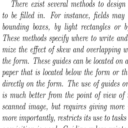

In [48]:
def to_PIL(torch_image):
    #assert 0 <= torch_image.min() and torch_image.max() <= 1
    torch_image = torch_image.permute(1, 2, 0).squeeze(-1)
    PIL_image = Image.fromarray(np.uint8(torch_image.detach().cpu().numpy() * 255))
    
    return PIL_image

torch_image = cleaned_image[0]
to_PIL(cleaned_image[1])    # 원본
#to_PIL(recons_image[1])

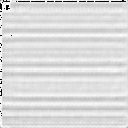

In [49]:
to_PIL(recons_image[0])

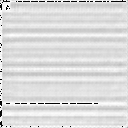

In [53]:
to_PIL(recons_image[10])